# Usage Demo : 


In [1]:
import mido
import glob
import numpy as np
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
from mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

## Absolute measurement: statistic analysis


Assign dataset path

In [2]:
set1 = glob.glob('data/output/*')
print(set1)


['data/output/generated_track_transformer_9.mid', 'data/output/generated_track_transformer_8.mid', 'data/output/generated_track_transformer_5.mid', 'data/output/generated_track_transformer_4.mid', 'data/output/generated_track_transformer_6.mid', 'data/output/generated_track_transformer_14.mid', 'data/output/generated_track_transformer_7.mid', 'data/output/generated_track_transformer_3.mid', 'data/output/generated_track_transformer_10.mid', 'data/output/generated_track_transformer_11.mid', 'data/output/generated_track_transformer_2.mid', 'data/output/generated_track_transformer_0.mid', 'data/output/generated_track_transformer_13.mid', 'data/output/generated_track_transformer_12.mid', 'data/output/generated_track_transformer_1.mid']


construct empty dictionary to fill in measurement across samples

In [3]:
#num_samples = 100
num_samples = 10
num_bar=8

In [4]:
set1_eval = {'total_used_pitch':np.zeros((num_samples,1)),'pitch_range': np.zeros((num_samples, 1)), 'avg_IOI': np.zeros((num_samples, 1)),'total_pitch_class_histogram': np.zeros((num_samples, 12))
          , 'bar_pitch_class_histogram': np.zeros((num_samples, num_bar, 12))
          , 'pitch_class_transition_matrix': np.zeros((num_samples, 12, 12))}
metrics_list = list(set1_eval.keys())
for i in range(0, num_samples):
    feature = core.extract_feature(set1[i])
    for j in range(0,len(metrics_list)):
        set1_eval[metrics_list[j]][i] = getattr(core.metrics(), metrics_list[j])(feature)

No instruments defined in the MIDI data. Assuming default piano.


repeat for second dataset

In [5]:
# set2 = glob.glob('../data/set2/*.mid')
set2 = glob.glob('data/baseline/*')
set2_eval = {'total_used_pitch':np.zeros((num_samples,1)),'pitch_range': np.zeros((num_samples, 1)), 'avg_IOI': np.zeros((num_samples, 1)),'total_pitch_class_histogram': np.zeros((num_samples, 12)) 
          , 'bar_pitch_class_histogram': np.zeros((num_samples, num_bar, 12))
          , 'pitch_class_transition_matrix': np.zeros((num_samples, 12, 12))}
for i in range(0, num_samples):
    feature = core.extract_feature(set2[i])
    for j in range(0,len(metrics_list)):
        set2_eval[metrics_list[j]][i] = getattr(core.metrics(), metrics_list[j])(feature)

No instruments defined in the MIDI data. Assuming default piano.
No instruments defined in the MIDI data. Assuming default piano.


statistic analysis: absolute measurement

In [6]:
for i in range(0, len(metrics_list)):
    print(metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(set1_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set1_eval[metrics_list[i]], axis=0))

    print('------------------------')
    print(' demo_set')
    print('  mean: ', np.mean(set2_eval[metrics_list[i]], axis=0))
    print('  std: ', np.std(set2_eval[metrics_list[i]], axis=0))


total_used_pitch:
------------------------
 demo_set
  mean:  [36.8]
  std:  [15.97372843]
------------------------
 demo_set
  mean:  [17.8]
  std:  [13.61469794]
pitch_range:
------------------------
 demo_set
  mean:  [58.7]
  std:  [26.92229559]
------------------------
 demo_set
  mean:  [27.9]
  std:  [18.9232661]
avg_IOI:
------------------------
 demo_set
  mean:  [0.23978935]
  std:  [0.12689012]
------------------------
 demo_set
  mean:  [0.8705777]
  std:  [0.67700859]
total_pitch_class_histogram:
------------------------
 demo_set
  mean:  [0.12255002 0.10902874 0.0989154  0.07614413 0.08235576 0.09811731
 0.01975931 0.07856265 0.05624158 0.03405183 0.08423437 0.04003889]
  std:  [0.07322079 0.21683153 0.08643197 0.08747026 0.08643277 0.1049082
 0.01794409 0.05974344 0.03669491 0.03327454 0.07673397 0.03138728]
------------------------
 demo_set
  mean:  [0.12814625 0.00535813 0.08892197 0.01399876 0.08547392 0.10011029
 0.03258008 0.14642545 0.01159264 0.10399236 0.033597

## Relative measurement: generalizes the result among features with various dimensions


the features are sum- marized to 
- the intra-set distances
- the difference of intra-set and inter-set distances.

exhaustive cross-validation for intra-set distances measurement

In [7]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
set1_intra = np.zeros((num_samples, len(metrics_list), num_samples))
set2_intra = np.zeros((num_samples, len(metrics_list), num_samples))
for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        dist_value = utils.c_dist(set1_eval[metrics_list[i]][test_index], set1_eval[metrics_list[i]][train_index])
        set1_intra[test_index[0], i] = np.mean(dist_value)  # Assuming you want the mean distance
        dist_value = utils.c_dist(set2_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]][train_index])
        set2_intra[test_index[0], i] = np.mean(dist_value)


exhaustive cross-validation for inter-set distances measurement

In [8]:
loo = LeaveOneOut()
loo.get_n_splits(np.arange(num_samples))
sets_inter = np.zeros((num_samples, len(metrics_list), num_samples))

for i in range(len(metrics_list)):
    for train_index, test_index in loo.split(np.arange(num_samples)):
        sets_inter[test_index[0]][i] = utils.c_dist(set1_eval[metrics_list[i]][test_index], set2_eval[metrics_list[i]])

visualization of intra-set and inter-set distances

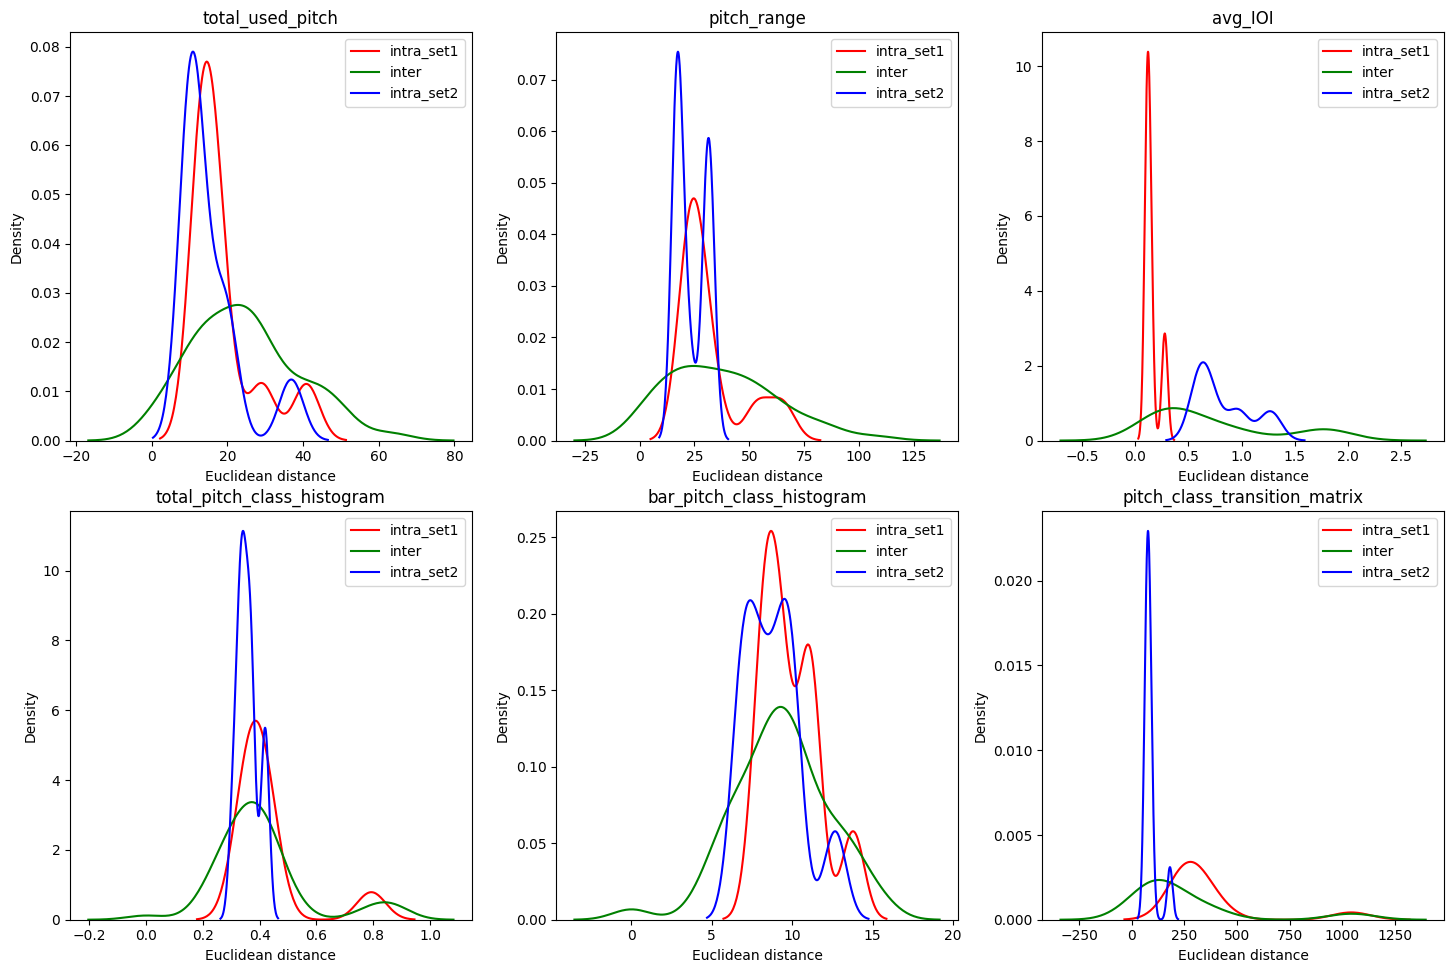

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming set1_intra, set2_intra, sets_inter, and metrics_list are predefined
plot_set1_intra = np.transpose(set1_intra, (1, 0, 2)).reshape(len(metrics_list), -1)
plot_set2_intra = np.transpose(set2_intra, (1, 0, 2)).reshape(len(metrics_list), -1)
plot_sets_inter = np.transpose(sets_inter, (1, 0, 2)).reshape(len(metrics_list), -1)

# Define the number of rows and columns for the subplot grid
n_rows = 2  # or any other configuration that fits your total number of plots
n_cols = 3  # make sure n_rows * n_cols >= len(metrics_list)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjust the figure size as needed
fig.tight_layout(pad=3.0)  # Adjust spacing between plots

for i in range(len(metrics_list)):
    row = i // n_cols
    col = i % n_cols

    sns.kdeplot(plot_set1_intra[i], ax=axs[row, col], color='red', label='intra_set1')
    sns.kdeplot(plot_sets_inter[i], ax=axs[row, col], color='green', label='inter')
    sns.kdeplot(plot_set2_intra[i], ax=axs[row, col], color='blue', label='intra_set2')

    axs[row, col].set_title(metrics_list[i])
    axs[row, col].set_xlabel('Euclidean distance')
    axs[row, col].legend()

# Hide any unused subplots if there are any
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs[j // n_cols, j % n_cols])

plt.show()


the difference of intra-set and inter-set distances.

In [10]:
for i in range(0, len(metrics_list)):
    print (metrics_list[i] + ':')
    print('------------------------')
    print(' demo_set1')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_set1_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set1_intra[i], plot_sets_inter[i]))
    
    print(' demo_set2')
    print('  Kullback–Leibler divergence:',utils.kl_dist(plot_set2_intra[i], plot_sets_inter[i]))
    print('  Overlap area:', utils.overlap_area(plot_set2_intra[i], plot_sets_inter[i]))
    

total_used_pitch:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.45996087904003335
  Overlap area: 0.5960840016298935
 demo_set2
  Kullback–Leibler divergence: 0.46136386638368687
  Overlap area: 0.5505363923836206
pitch_range:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.33461931280590834
  Overlap area: 0.5947909983179657
 demo_set2
  Kullback–Leibler divergence: 0.4512236908732781
  Overlap area: 0.36699534576697745
avg_IOI:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.13162319380825752
  Overlap area: 0.20312685545257003
 demo_set2
  Kullback–Leibler divergence: 0.05725869415273769


/Users/lixiang/Desktop/mgeval_python3/mgeval/utils.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda x: min(pdf_A(x), pdf_B(x)), np.min((np.min(A), np.min(B))), np.max((np.max(A), np.max(B))))[0]


  Overlap area: 0.4346689125358181
total_pitch_class_histogram:
------------------------
 demo_set1
  Kullback–Leibler divergence: 1.7872523676319942
  Overlap area: 0.7237620317240226
 demo_set2
  Kullback–Leibler divergence: 0.341729545981355
  Overlap area: 0.4911859129233324
bar_pitch_class_histogram:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.9701488405799306
  Overlap area: 0.7093714525042182
 demo_set2
  Kullback–Leibler divergence: 0.8528279650918683
  Overlap area: 0.7071151678188861
pitch_class_transition_matrix:
------------------------
 demo_set1
  Kullback–Leibler divergence: 0.13821591372870096
  Overlap area: 0.5768260724958107
 demo_set2
  Kullback–Leibler divergence: 0.05708075794339475
  Overlap area: 0.2589600285590036
